# CARsifier

The model we are using would be the VGG16 and using transfer learning, we are training the model for our specific use (to classify the different car models, CARSify).  
You can download the dataset from [here](https://www.kaggle.com/jessicali9530/stanford-cars-dataset)

In [30]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [31]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading the datasets

In [33]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

train_data_path = '/home/heizer/deep_learning/Stanford_cars/cars_train'
train_dataset = torchvision.datasets.ImageFolder(root=train_data_path,transform=transform)

test_data_path = '/home/heizer/deep_learning/Stanford_cars/cars_test'
test_dataset = torchvision.datasets.ImageFolder(root=test_data_path,transform=transform)

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True
)

## Loading the different classes 

In [34]:
import csv

def car_class_list():
    name_list = []
    with open('/home/heizer/deep_learning/Datasets/names.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data = row.get(None)
            name_list.append(data[0])
        return name_list
    
def get_car_classes(id):
    classes = car_class_list()
    return classes[id]
    
# data = dictionary.get("message", "")
car_classes = car_class_list()
# print(len(car_classes))

In [35]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std)
#     ])

# trainset = ('/home/heizer/deep_learning/Datasets/car_data/train',train=True, download=True,transform=transform)
# testset = ('/home/heizer/deep_learning/Datasets/car_data/test',train=False, transform=transform)

# trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
# testloader = DataLoader(testset, batch_size=32, shuffle=False)

## Loading the model (VGG16) 

In [36]:
model = models.vgg16(pretrained=True)

In [37]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [38]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [39]:
for param in model.parameters():
  param.requires_grad=False

In [40]:
model.classifier[-1] = nn.Sequential(nn.Linear(in_features=4096, out_features=196),
                                     nn.LogSoftmax(dim=1))

In [41]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=196, bias=True)
    (1): LogSoftmax()
  )
)

In [42]:
criterion = nn.NLLLoss()

In [43]:
from torch.optim import Adam

In [44]:
model = model.to(device)
optimizer = Adam(model.parameters())

## Training the model

In [ ]:
num_epochs = 5
batch_loss = 0
cum_epoch_loss = 0

for e in range(num_epochs):
  cum_epoch_loss = 0
  
  for batch, (images, labels) in enumerate(trainloader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
    
  print(f'Training loss : {batch_loss/len(trainloader)}')  

Epoch(0/5 : Batch number(1/255)  Batch loss : 5.623013973236084
Epoch(0/5 : Batch number(2/255)  Batch loss : 3.7498772144317627
Epoch(0/5 : Batch number(3/255)  Batch loss : 2.139007091522217
Epoch(0/5 : Batch number(4/255)  Batch loss : 0.9705089330673218
Epoch(0/5 : Batch number(5/255)  Batch loss : 0.3043883442878723
Epoch(0/5 : Batch number(6/255)  Batch loss : 0.0825294703245163
Epoch(0/5 : Batch number(7/255)  Batch loss : 0.046847857534885406
Epoch(0/5 : Batch number(8/255)  Batch loss : 0.015170909464359283
Epoch(0/5 : Batch number(9/255)  Batch loss : 0.00808260589838028
Epoch(0/5 : Batch number(10/255)  Batch loss : 0.00641120970249176
Epoch(0/5 : Batch number(11/255)  Batch loss : 0.001088663935661316
Epoch(0/5 : Batch number(12/255)  Batch loss : 0.0012282133102416992
Epoch(0/5 : Batch number(13/255)  Batch loss : 0.00023537874221801758
Epoch(0/5 : Batch number(14/255)  Batch loss : 0.0011615902185440063
Epoch(0/5 : Batch number(15/255)  Batch loss : 0.0002645254135131836


Epoch(0/5 : Batch number(120/255)  Batch loss : 1.9982457160949707e-05
Epoch(0/5 : Batch number(121/255)  Batch loss : 1.5467405319213867e-05
Epoch(0/5 : Batch number(122/255)  Batch loss : 8.806586265563965e-06
Epoch(0/5 : Batch number(123/255)  Batch loss : 3.471970558166504e-06
Epoch(0/5 : Batch number(124/255)  Batch loss : 2.086162567138672e-06
Epoch(0/5 : Batch number(125/255)  Batch loss : 8.940696716308594e-07
Epoch(0/5 : Batch number(126/255)  Batch loss : 2.2113323211669922e-05
Epoch(0/5 : Batch number(127/255)  Batch loss : 6.5267086029052734e-06
Epoch(0/5 : Batch number(128/255)  Batch loss : 1.6391277313232422e-06
Epoch(0/5 : Batch number(129/255)  Batch loss : 8.52346420288086e-06
Epoch(0/5 : Batch number(130/255)  Batch loss : 3.0994415283203125e-06
Epoch(0/5 : Batch number(131/255)  Batch loss : 1.3113021850585938e-06
Epoch(0/5 : Batch number(132/255)  Batch loss : 1.2949109077453613e-05
Epoch(0/5 : Batch number(133/255)  Batch loss : 4.500150680541992e-06
Epoch(0/5 : B

Epoch(0/5 : Batch number(237/255)  Batch loss : 3.889203071594238e-06
Epoch(0/5 : Batch number(238/255)  Batch loss : 5.185604095458984e-06
Epoch(0/5 : Batch number(239/255)  Batch loss : 7.525086402893066e-06
Epoch(0/5 : Batch number(240/255)  Batch loss : 3.516674041748047e-06
Epoch(0/5 : Batch number(241/255)  Batch loss : 2.7120113372802734e-06
Epoch(0/5 : Batch number(242/255)  Batch loss : 3.2007694244384766e-05
Epoch(0/5 : Batch number(243/255)  Batch loss : 5.841255187988281e-06
Epoch(0/5 : Batch number(244/255)  Batch loss : 1.7881393432617188e-06
Epoch(0/5 : Batch number(245/255)  Batch loss : 2.6226043701171875e-06
Epoch(0/5 : Batch number(246/255)  Batch loss : 7.748603820800781e-06
Epoch(0/5 : Batch number(247/255)  Batch loss : 6.973743438720703e-06
Epoch(0/5 : Batch number(248/255)  Batch loss : 2.0503997802734375e-05
Epoch(0/5 : Batch number(249/255)  Batch loss : 8.448958396911621e-06
Epoch(0/5 : Batch number(250/255)  Batch loss : 2.631545066833496e-05
Epoch(0/5 : Bat

Epoch(1/5 : Batch number(100/255)  Batch loss : 1.0773539543151855e-05
Epoch(1/5 : Batch number(101/255)  Batch loss : 1.1786818504333496e-05
Epoch(1/5 : Batch number(102/255)  Batch loss : 4.127621650695801e-06
Epoch(1/5 : Batch number(103/255)  Batch loss : 1.2576580047607422e-05
Epoch(1/5 : Batch number(104/255)  Batch loss : 3.2186508178710938e-06
Epoch(1/5 : Batch number(105/255)  Batch loss : 1.615285873413086e-05
Epoch(1/5 : Batch number(106/255)  Batch loss : 6.064772605895996e-06
Epoch(1/5 : Batch number(107/255)  Batch loss : 3.2633543014526367e-06
Epoch(1/5 : Batch number(108/255)  Batch loss : 2.8461217880249023e-06
Epoch(1/5 : Batch number(109/255)  Batch loss : 9.015202522277832e-06
Epoch(1/5 : Batch number(110/255)  Batch loss : 4.470348358154297e-07
Epoch(1/5 : Batch number(111/255)  Batch loss : 2.0384788513183594e-05
Epoch(1/5 : Batch number(112/255)  Batch loss : 5.692243576049805e-06
Epoch(1/5 : Batch number(113/255)  Batch loss : 7.420778274536133e-06
Epoch(1/5 : B

Epoch(1/5 : Batch number(217/255)  Batch loss : 6.690621376037598e-06
Epoch(1/5 : Batch number(218/255)  Batch loss : 1.8283724784851074e-05
Epoch(1/5 : Batch number(219/255)  Batch loss : 3.6954879760742188e-06
Epoch(1/5 : Batch number(220/255)  Batch loss : 1.1324882507324219e-06
Epoch(1/5 : Batch number(221/255)  Batch loss : 1.1563301086425781e-05
Epoch(1/5 : Batch number(222/255)  Batch loss : 1.9371509552001953e-06
Epoch(1/5 : Batch number(223/255)  Batch loss : 2.8133392333984375e-05
Epoch(1/5 : Batch number(224/255)  Batch loss : 4.693865776062012e-06
Epoch(1/5 : Batch number(225/255)  Batch loss : 5.3942203521728516e-06
Epoch(1/5 : Batch number(226/255)  Batch loss : 3.591179847717285e-06
Epoch(1/5 : Batch number(227/255)  Batch loss : 5.662441253662109e-06
Epoch(1/5 : Batch number(228/255)  Batch loss : 1.1116266250610352e-05
Epoch(1/5 : Batch number(229/255)  Batch loss : 3.4570693969726562e-06
Epoch(1/5 : Batch number(230/255)  Batch loss : 4.172325134277344e-07
Epoch(1/5 :

In [16]:
torch.save(model.state_dict(), '/home/heizer/deep_learning/model.pt')

## Evaluating the network and viewing images

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [70]:
model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)

tensor([[1.0000e+00, 1.6540e-09, 1.3729e-09,  ..., 9.9616e-10, 2.3837e-09,
         1.3405e-09],
        [9.9994e-01, 4.9574e-07, 2.5606e-07,  ..., 1.9226e-07, 3.1988e-07,
         2.4860e-07],
        [9.9949e-01, 2.6068e-06, 3.2235e-06,  ..., 2.3552e-06, 2.6705e-06,
         2.4814e-06],
        ...,
        [1.0000e+00, 1.1274e-08, 3.5832e-09,  ..., 4.9751e-09, 7.7760e-09,
         3.9839e-09],
        [1.0000e+00, 9.8642e-10, 7.0737e-10,  ..., 7.6204e-10, 1.1016e-09,
         7.4868e-10],
        [1.0000e+00, 2.4141e-09, 4.5249e-09,  ..., 2.6166e-09, 3.8541e-09,
         2.8485e-09]])


In [18]:
model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  
  pred = torch.argmax(output,1) #take the prediction with the highest value
    
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Chevrolet Sonic Sedan 2012


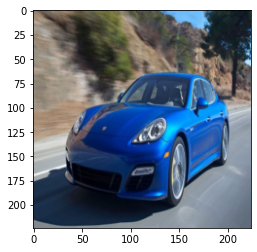

In [28]:
test_image_id=30

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)

show_img(images[test_image_id])
print(get_car_classes(pred[test_image_id]))